# Info

Read in my exported Letterboxd data and the MovieLens 32M dataset. Characterize features and transformations to join between the Letterboxd data and MovieLens dataset.

# Prep Data

Map IMDB ID from Letterboxd URI so that it can be merged with MovieLens dataset. Reference for function: [letterboxd2imdb.py](https://github.com/TobiasPankner/Letterboxd-to-IMDb/blob/master/letterboxd2imdb.py)

Then, output a combined ratings dataset that will be used as the input for the SVD model.

Letterboxd data is sourced from their website's CSV export. The zipped contents are extracted and kept under `data/letterboxd`. MovieLens 32M dataset is downloaded from [here](https://grouplens.org/datasets/movielens/32m/), with the zipped contents are extracted and kept under `data/ml-32m`

In [1]:
import os
import pandas as pd
import numpy as np
from surprise import Dataset
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import re

def get_imdb_id(letterboxd_uri):
  headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/123.0.0.0 Safari/537.36",
    "Accept": "text/html",
    "Accept-Language": "en-US,en;q=0.9",
    "Connection": "keep-alive",
    "Cache-Control": "max-age=0",
  }

  resp = requests.get(letterboxd_uri, headers=headers)
  if resp.status_code != 200:
    return None

  # extract the IMDb url
  re_match = re.findall(r'href=".+title/(tt\d+)/maindetails"', resp.text)
  if not re_match:
    return None

  return re_match[0].replace('tt', '')

# import movielens data
data_dir = '../data_dl/'
data_dir_ml = os.path.join(data_dir, 'ml-32m')
# dimension table for film list
df_films = pd.merge(
    pd.read_csv(os.path.join(data_dir_ml, 'movies.csv')),
    pd.read_csv(os.path.join(data_dir_ml, 'links.csv')),
    how='left', on='movieId'
  ) \
  .drop('tmdbId', axis=1) \
  .rename(columns={'movieId':'movie_id', 'imdbId':'imdb_id'})                    
df_ratings = pd.read_csv(os.path.join(data_dir_ml, 'ratings.csv')) \
  .rename(columns={'userId':'user_id','movieId':'movie_id',})

In [ ]:
# for letterboxd data, re-read when desired so that mapping to IMDB doesn't have to get run every time
lb_rerun = False
my_id=999999
data_dir_lb = os.path.join(data_dir, 'letterboxd')
if lb_rerun:
  # letterboxd data
  df_ratings_ec = pd.read_csv(os.path.join(data_dir_lb, 'ratings.csv')) \
    .set_axis(['date', 'title', 'year', 'lb_uri', 'rating'], axis=1) \
    .assign(decade = lambda x: (x['year'] // 10) * 10)
  # use diary for watch counts
  df_log_counts = pd.read_csv(os.path.join(data_dir_lb, 'diary.csv')) \
    .groupby(['Name', 'Year']).size().reset_index(name='n_logs') \
    .assign(rewatched = lambda x: np.where(x.n_logs > 1, True, False)) \
    .rename(columns={'Name':'title', 'Year':'year'})
  df_lb = pd.merge(df_ratings_ec, df_log_counts, how='left', on=['title', 'year']) \
    .fillna({'n_logs':0}) # never logged = NA -> 0
  df_lb['imdb_id'] = pd.to_numeric(df_lb['lb_uri'].apply(get_imdb_id))
  df_lb = pd.merge(
    df_lb,
    df_films[['imdb_id', 'movie_id']],
    how='inner', # inner join - only want to keep common set of titles
    on='imdb_id'
  )
  
  # add myself to ratings database, with my ID being 999999
  df_ratings_with_ec = pd.concat([
    df_lb.assign(user_id=my_id)[['user_id', 'movie_id', 'rating']],
    df_ratings[['user_id', 'movie_id', 'rating']]
  ])

  # write out
  df_lb.to_csv(os.path.join(data_dir_lb, 'lb_joined.csv'), index=False)
  df_ratings_with_ec.to_parquet('../data/ratings_combined.parquet') # large file - save as parquet for size considerations
else: 
  df_lb = pd.read_csv(os.path.join(data_dir_lb, 'lb_joined.csv'))
  df_ratings_with_ec = pd.read_parquet('../data/ratings_combined.parquet')

# EDA

## Rating Counts per User

Text(0.5, 1.0, 'Rating counts for each user')

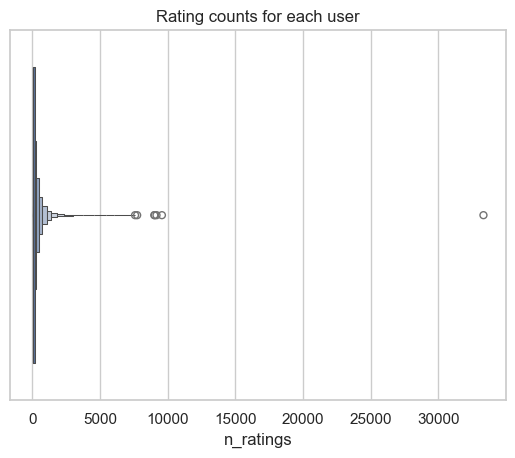

In [9]:
sns.set_theme(style="whitegrid")

df = df_ratings_with_ec.groupby('user_id').agg(n_ratings = pd.NamedAgg(column='movie_id', aggfunc='count'))
sns.boxenplot(df, x='n_ratings')
plt.title('Rating counts for each user')

Exclude highest outlier, and demarcating where I fall in the distribution

Text(0.5, 1.0, 'Rating counts for each user, without highest outlier')

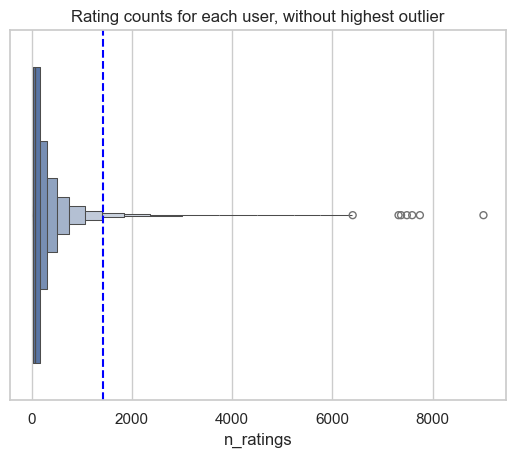

In [31]:
df = df[df['n_ratings'] < max(df['n_ratings'])]

sns.boxenplot(df, x='n_ratings')
plt.axvline(x=df[df.index==999999].iat[0,0], color='blue', linestyle='--')
plt.title('Rating counts for each user, without highest outlier')

## Ratings Distribution

Text(0.5, 1.0, 'Distribution of Ratings')

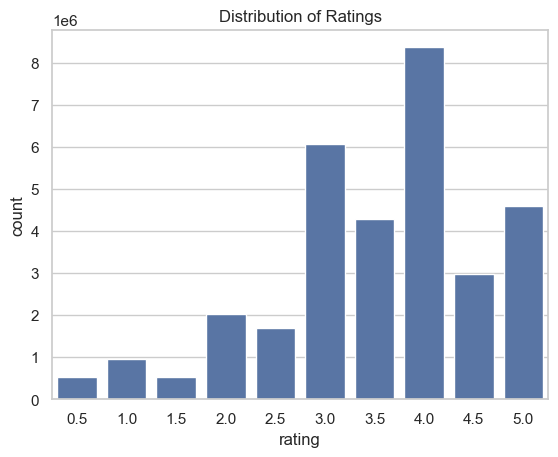

In [32]:
df = df_ratings_with_ec

sns.countplot(x='rating', data=df)
plt.title('Distribution of Ratings')

Text(0.5, 1.0, 'Distribution of EC Ratings')

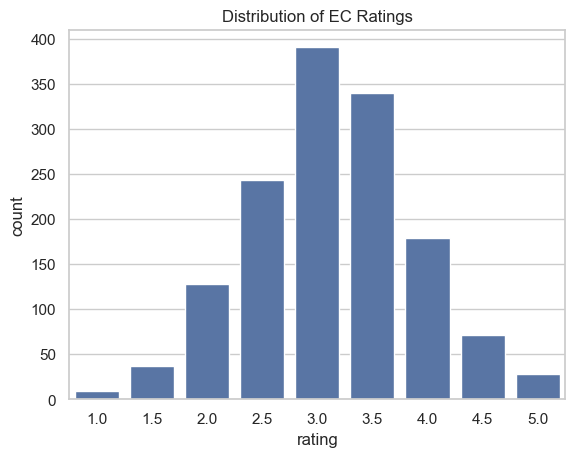

In [33]:
df = df[df['user_id'] == my_id]

sns.countplot(x='rating', data=df)
plt.title('Distribution of EC Ratings')

## Most Popular Films

Top 25's for each most watched and highest rated (TODO set minimum ratings?)

Each plot also color codes ones that I have not watched yet

Text(0.5, 1.0, 'Most Watched Films')

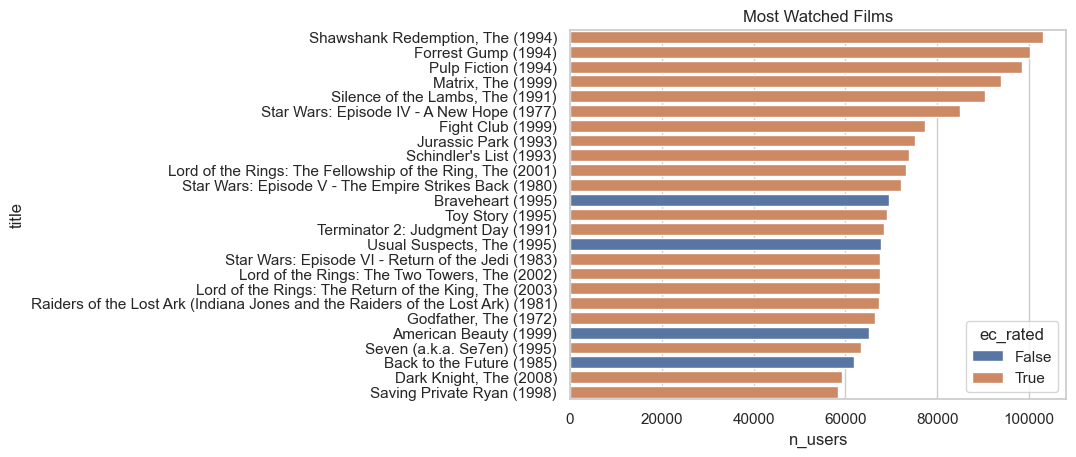

In [34]:
top_n = 25

ec_films = df_ratings_with_ec[df_ratings_with_ec['user_id']==my_id]['movie_id'].to_list()

df_popularity = df_ratings_with_ec.groupby('movie_id') \
  .agg(
    n_users = pd.NamedAgg(column='user_id', aggfunc='count'), 
    avg_rating = pd.NamedAgg(column='rating', aggfunc='mean')
  ) \
  .reset_index() \
  .merge(
    df_films[['movie_id', 'title']],
    how='left', on=['movie_id']
  ) \
  .assign(
    ec_rated = lambda x: np.where(x['movie_id'].isin(ec_films), True, False)
  )

df = df_popularity.sort_values('n_users', ascending=False).head(top_n)

sns.barplot(df, x="n_users", y="title", hue="ec_rated", legend=True)
plt.title('Most Watched Films')

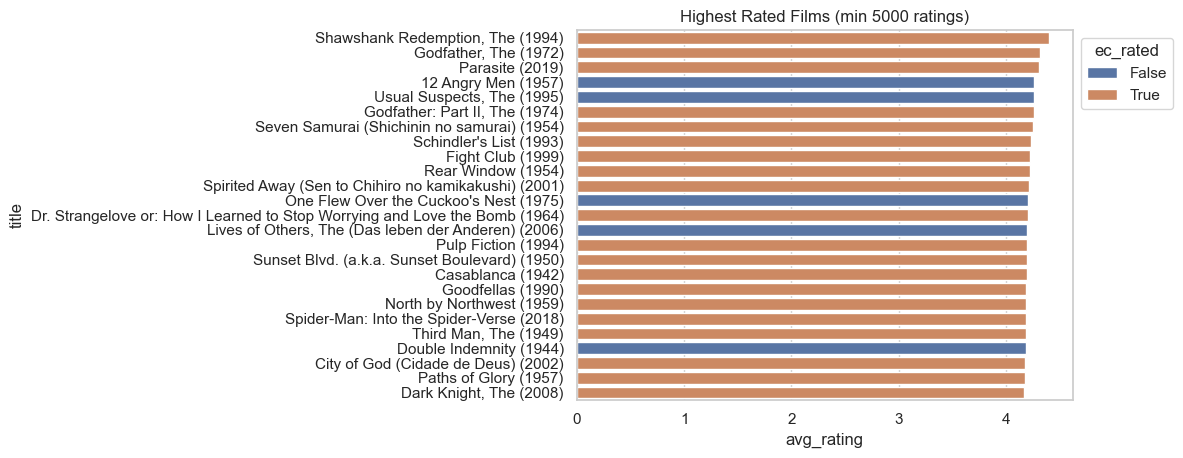

In [35]:
min_count = 5000
df = df_popularity[df_popularity['n_users'] >= min_count].sort_values('avg_rating', ascending=False).head(top_n)

g = sns.barplot(df, x="avg_rating", y="title", hue="ec_rated", legend=True)
plt.title(f'Highest Rated Films (min {min_count} ratings)')
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))

## Additional Letterboxd EDA (TODO)

Further characterizations & superlatives of my Letterboxd data (mostly just for fun, as they're uninvolved in SVD):

* Letterboxd log count/rewatches
* Year or Decade characterizations/superlatives
* Highest rated/most rewatched compared against MovieLens' ratings